In [2]:
%matplotlib inline

import datetime as dt

import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")
from scipy.optimize import curve_fit
import math
from tqdm import tqdm

# Largest Context:
#sns.set_context("talk")

#from metpy.calc import dewpoint_from_relative_humidity
#from metpy.cbook import get_test_data
#from metpy.plots import add_metpy_logo
from metpy.units import units
import xarray as xr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import pyart

import os


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
#Data Logger Data Import Cell
# Height of the station to calculate MSLP
hgt_example = 206.

def calc_mslp(t, p, h):
    return p * (1 - (0.0065 * h) / (t + 0.0065 * h + 273.15)) ** (-5.257)

testdata = pd.read_csv('/data/accp/a/snesbitt/scamp-2023/LoggerNet/SCAMPCR6_SCAMP_1min - Copy.dat',header=1).drop([0,1])
testdata2 = pd.read_csv('/data/accp/a/snesbitt/scamp-2023/LoggerNet/SCAMPCR6_SCAMP_1min.dat',header=1).drop([0,1])
testdata3 = pd.read_csv('/data/accp/a/snesbitt/scamp-2023/LoggerNet/SCAMPCR6_SCAMP_2022_1min.dat',header=1).drop([0,1])

data_all = pd.concat([testdata,testdata2,testdata3]).replace('NAN',np.nan)

data_all['Time_Eastern'] = pd.to_datetime(data_all['TIMESTAMP'])+pd.Timedelta(value=1, unit='hours')
# testdata_all=testdata_all.set_index('Time_Eastern')

timestamps_est = np.array(data_all.Time_Eastern, dtype=dt.datetime)
temp_times = np.zeros(len(timestamps_est),dtype=dt.datetime)
for i in range(len(timestamps_est)):
    temp_times[i] = timestamps_est[i]+pd.Timedelta(value=5, unit='hours')

data_all['UTC'] = temp_times
data_all=data_all.set_index('UTC')

data_all['Geonor_Freq'][185486] = float("nan")
data_all['Current_Depth'][185486] = float("nan")
data_all['Precip_Rate'][185487] = float("nan")

data_all['Geonor_Freq'][204447] = float("nan")
data_all['Current_Depth'][204447] = float("nan")
data_all['Precip_Rate'][204448] = float("nan")

data_all['Geonor_Freq'][223988] = float("nan")
data_all['Current_Depth'][223988] = float("nan")
data_all['Precip_Rate'][223989] = float("nan")

data_all['Geonor_Freq'][255972] = float("nan")
data_all['Current_Depth'][255972] = float("nan")
data_all['Precip_Rate'][255973] = float("nan")

data_all['Geonor_Freq'][256036] = float("nan")
data_all['Current_Depth'][256036] = float("nan")
data_all['Precip_Rate'][256037] = float("nan")

data_all['Geonor_Freq'][264175] = float("nan")
data_all['Current_Depth'][264175] = float("nan")
data_all['Precip_Rate'][264176] = float("nan")

data_all['Geonor_Freq'][268822] = float("nan")
data_all['Current_Depth'][268822] = float("nan")
data_all['Precip_Rate'][268823] = float("nan")

/tmp/ipykernel_5207/953111246.py:9: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  testdata2 = pd.read_csv('/data/accp/a/snesbitt/scamp-2023/LoggerNet/SCAMPCR6_SCAMP_1min.dat',header=1).drop([0,1])
/tmp/ipykernel_5207/953111246.py:10: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  testdata3 = pd.read_csv('/data/accp/a/snesbitt/scamp-2023/LoggerNet/SCAMPCR6_SCAMP_2022_1min.dat',header=1).drop([0,1])
/tmp/ipykernel_5207/953111246.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_all['Geonor_Freq'][185486] = float("nan")
/tmp/ipykernel_5207/953111246.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [4]:
snowcases = ['20220117','20221118','20221223']
for z in range(len(snowcases)):
    if snowcases[z] == '20220117':
        event_type = 'snow'
        dates = pd.date_range(start='2022-01-17',end='2022-01-17')
    elif snowcases[z] == '20221118':
        event_type = 'snow'
        dates = pd.date_range(start='2022-11-18',end='2022-11-20')
    elif snowcases[z] =='20221223':
        event_type = 'snow'
        dates = pd.date_range(start='2022-12-23',end='2022-12-25')

    for idate in dates:
        ds = xr.open_mfdataset('/data/keeling/a/mp46/Research/Processed_Data/'+idate.strftime('%Y%m%d')+'_BUFtest.nc')

        drop_velocity = np.array(ds.velocity) 
        drop_diameter = np.array(ds.diameter)
    
        t1=idate
        #t2=idate+pd.Timedelta(1, unit='D')
        t2=idate+pd.Timedelta(hours=23,minutes=59)
        gauge_mask_for_day = (data_all.index >= t1) & (data_all.index <= t2)
        daily_gauge_data = data_all.loc[gauge_mask_for_day]
        gauge_mask_for_pd = (daily_gauge_data.index >= t1) & (daily_gauge_data.index <= t2)

        #algorithm for data smoothing)
        if gauge_mask_for_pd.sum() > 0:

            if idate.strftime('%Y%m%d') == '20221226':
                temp_gauge_data = daily_gauge_data.loc[gauge_mask_for_pd]

                temp_parsivel_rr_data = xr.DataArray.to_series(ds.avg_rainrate)
                temp_parsivel_rr_data = np.concatenate([temp_parsivel_rr_data,np.zeros(1163)],axis=0)
                temp_parsivel_rr_data = temp_parsivel_rr_data[gauge_mask_for_pd]
                temp_parsivel_ds_spectrum = np.array(ds['spectrum'])
                temp_parsivel_ds_spectrum = np.concatenate([temp_parsivel_ds_spectrum,np.zeros((1163,32,32))],axis=0)
                parsivel_ds_spectrum = temp_parsivel_ds_spectrum[gauge_mask_for_pd]
                temp_parsivel_dsd = np.array(ds['dsd'])
                temp_parsivel_dsd = np.concatenate([temp_parsivel_dsd,np.zeros((1163,32))],axis=0)
                parsivel_dsd = temp_parsivel_dsd[gauge_mask_for_pd]
                temp_parsivel_mass_spec = np.array(ds['raindrop_mass_spectrum_bins'])
                temp_parsivel_mass_spec = np.concatenate([temp_parsivel_mass_spec,np.zeros((1163,32))],axis=0)
                parsivel_mass_spec = temp_parsivel_mass_spec[gauge_mask_for_pd]

                temp_parsivel_LWC = np.array(ds['Williams_LWC_bins'])
                temp_parsivel_LWC = np.concatenate([temp_parsivel_LWC,np.zeros((1163,32))],axis=0)
                parsivel_LWC = temp_parsivel_LWC[gauge_mask_for_pd]

            else:
                temp_gauge_data = daily_gauge_data.loc[gauge_mask_for_pd]
                temp_parsivel_rr_data = xr.DataArray.to_series(ds.avg_rainrate)
                temp_parsivel_rr_data = temp_parsivel_rr_data.loc[gauge_mask_for_pd]
                temp_parsivel_ds_spectrum = np.array(ds['spectrum'])
                parsivel_ds_spectrum = temp_parsivel_ds_spectrum[gauge_mask_for_pd]
                temp_parsivel_dsd = np.array(ds['dsd'])
                parsivel_dsd = temp_parsivel_dsd[gauge_mask_for_pd]
                temp_parsivel_IWC = np.array(ds['IWC_bins'])
                temp_parsivel_IWC = temp_parsivel_IWC[gauge_mask_for_pd]
                temp_parsivel_mass_spec = np.array(ds['raindrop_mass_spectrum_bins'])
                parsivel_mass_spec = temp_parsivel_mass_spec[gauge_mask_for_pd]
                temp_psd_dbz = np.array(ds['total_dbz'])
                psd_dbz = temp_psd_dbz[gauge_mask_for_pd]
                temp_parsivel_LWC = np.array(ds['Williams_LWC_bins'])
                parsivel_LWC = temp_parsivel_LWC[gauge_mask_for_pd]

                temp_parsivel_dm = np.array(ds['mass_mean_diameter'])
                parsivel_dm = temp_parsivel_dm[gauge_mask_for_pd]

            thirtyminstart = t1
            thirtyminend = thirtyminstart+pd.Timedelta(minutes=29)

            while thirtyminend <= temp_gauge_data.index[len(temp_gauge_data)-1]:

                maskminute = (temp_gauge_data.index >= thirtyminstart) & (temp_gauge_data.index <= thirtyminend)
                thirtymindata = temp_gauge_data.loc[maskminute] 
                # here, current depth is in mm
                P = np.diff(pd.to_numeric(thirtymindata['Current_Depth'],errors='coerce')) #P is in mm/min
                P = np.concatenate([[0],P],axis=0)
                #P = sorted(P)
                flaggedvalues = (pd.to_numeric(P) <= 0.05)
                for i in range(len(P)):
                    #if P[i] < 0: #if P value is negative
                    #   P[i] = 0 #make it equal to 0
                    if flaggedvalues[i] == True: #if the value is less than 0.1
                        if i == 29: #check to see if it's the last value in the 30 mins
                            if P[i] < 0.05: #if so, check to see if it's less than 0.05
                                P[i] = P[i-1] + P[i]
                                #P[i] = 0 #if so, make it O because it means it's still below the minimum threshold
                        else: #if it's not the last value
                            P[i+1] = P[i+1] + P[i] #take the P value and add it to the subsequent value
                            P[i] = 0 #then make current value equal to 0
                if thirtyminstart == t1:
                    proc_precip_rate_temp = P #in mm/min
                else:
                    proc_precip_rate_temp = np.concatenate((proc_precip_rate_temp,P))
                thirtyminstart = thirtyminend +pd.Timedelta(minutes=1)
                thirtyminend = thirtyminstart+pd.Timedelta(minutes=29)

            precip_temp = pd.to_numeric(temp_gauge_data['Current_Depth'],errors='coerce')
            parsivel_daily_temp = np.nancumsum(temp_parsivel_rr_data/60)
            proc_daily_temp = np.nancumsum(proc_precip_rate_temp)
            freq_temp = pd.to_numeric(temp_gauge_data['Geonor_Freq'],errors='coerce')
            date_temp = pd.to_datetime(temp_gauge_data.index) #+ dt.timedelta(hours=1)

            #if idate == dates[0]:
            proc_daily = proc_daily_temp
            parsivel_daily = parsivel_daily_temp
            precip = precip_temp
            freq = freq_temp
            date = date_temp
            parsivelrr = temp_parsivel_rr_data
            proc_precip_rate = proc_precip_rate_temp

    #################################################################################################################################################################        
            def power_law(x, a, b):
                return a*np.power(x, b)

            summed_spectrum = parsivel_ds_spectrum.sum(axis=0)
            separate_diameters = []
            separate_velocities = []

            time_labels = np.array(date)

            snow_upper_limit = 0.8*np.power(drop_diameter, 0.16) + 1
            snow_lower_limit = 0.8*np.power(drop_diameter, 0.16) - 1
            rain_upper_limit = 17.67*np.power(drop_diameter/10, 0.67) + 1 
            rain_lower_limit = 17.67*np.power(drop_diameter/10, 0.67) - 1

            rain_dict_temp = {}

            for d,u,l in zip(range(len(drop_diameter)), rain_upper_limit, rain_lower_limit):
                rain_indis = np.where( (drop_velocity>l))
                rain_dict_temp[d] = rain_indis

            rain_indi_pairs_2D = []
            for rain_diam, rain_indis in rain_dict_temp.items():
                for i in rain_indis[0]:
                    if summed_spectrum[i, rain_diam] > 0:
                        rain_indi_pairs_2D.append((rain_diam,i))

            rain_triple_time_dia_vel = []

            for i, j in rain_indi_pairs_2D:
                local_dia = drop_diameter[i]
                local_veloc = drop_velocity[j]
                times = parsivel_ds_spectrum[:,j,i]
                time_indis = np.where(times>0)
                for t in time_indis[0]:
                    rain_triple_time_dia_vel.append((local_dia,local_veloc,time_labels[t]))

            rain_triple_time_dia_vel = np.array(rain_triple_time_dia_vel)

            ####################################################################

            snow_dict_temp = {}

            for d,u,l in zip(range(len(drop_diameter)), snow_upper_limit, snow_lower_limit):
                snow_indis = np.where((drop_velocity<u) & (drop_velocity>l))
                snow_dict_temp[d] = snow_indis

            snow_indi_pairs_2D = []
            for snow_diam, snow_indis in snow_dict_temp.items():
                for i in snow_indis[0]:
                    if summed_spectrum[i, snow_diam] > 0:
                        snow_indi_pairs_2D.append((snow_diam,i))

            snow_triple_time_dia_vel = []

            for i, j in snow_indi_pairs_2D:
                local_dia = drop_diameter[i]
                local_veloc = drop_velocity[j]
                times = parsivel_ds_spectrum[:,j,i]
                time_indis = np.where(times>0)
                for t in time_indis[0]:
                    snow_triple_time_dia_vel.append((local_dia,local_veloc,time_labels[t]))

            snow_triple_time_dia_vel = np.array(snow_triple_time_dia_vel)

            ########################################################################################

            mixed_dict_temp = {}

            for d,u,l in zip(range(len(drop_diameter)), snow_upper_limit, rain_lower_limit):
                mixed_indis = np.where((drop_velocity>u) & (drop_velocity<l))
                mixed_dict_temp[d] = mixed_indis

            mixed_indi_pairs_2D = []
            for mixed_diam, mixed_indis in mixed_dict_temp.items():
                for i in mixed_indis[0]:
                    if summed_spectrum[i, mixed_diam] > 0:
                        mixed_indi_pairs_2D.append((mixed_diam,i))

            mixed_triple_time_dia_vel = []

            for i, j in mixed_indi_pairs_2D:
                local_dia = drop_diameter[i]
                local_veloc = drop_velocity[j]
                times = parsivel_ds_spectrum[:,j,i]
                time_indis = np.where(times>0)
                for t in time_indis[0]:
                    mixed_triple_time_dia_vel.append((local_dia,local_veloc,time_labels[t]))

            mixed_triple_time_dia_vel = np.array(mixed_triple_time_dia_vel)

            ########################################################################################

            unknown_dict_temp = {}

            for d,u,l,rl in zip(range(len(drop_diameter)), snow_upper_limit, snow_lower_limit, rain_lower_limit):
                unknown_indis = np.where((drop_velocity>rl) & (l<drop_velocity) & (drop_velocity<u))
                unknown_dict_temp[d] = unknown_indis

            unknown_indi_pairs_2D = []
            for unknown_diam, unknown_indis in unknown_dict_temp.items():
                for i in unknown_indis[0]:
                    if summed_spectrum[i, unknown_diam] > 0:
                        unknown_indi_pairs_2D.append((unknown_diam,i))

            unknown_triple_time_dia_vel = []

            for i, j in unknown_indi_pairs_2D:
                local_dia = drop_diameter[i]
                local_veloc = drop_velocity[j]
                times = parsivel_ds_spectrum[:,j,i]
                time_indis = np.where(times>0)
                for t in time_indis[0]:
                    unknown_triple_time_dia_vel.append((local_dia,local_veloc,time_labels[t]))

            unknown_triple_time_dia_vel = np.array(unknown_triple_time_dia_vel)

            ################################################################################################################################################################################
            
            # Fit the power-law data
            snow_pars, snow_cov = curve_fit(f=power_law, xdata=snow_triple_time_dia_vel[:,0]/1000, ydata=snow_triple_time_dia_vel[:,1], p0=[0.006, 0.05], bounds=(0, [np.inf, 1]), check_finite=False)
            # Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
            snow_stdevs = np.sqrt(np.diag(snow_cov))
            # Calculate the residuals
            snow_res = ds.velocity - power_law(ds.diameter, *snow_pars)

            rain_pars, rain_cov = curve_fit(f=power_law, xdata=rain_triple_time_dia_vel[:,0]/1000, ydata=rain_triple_time_dia_vel[:,1], p0=[0.006, 0.05], bounds=(0, [np.inf, 1]), check_finite=False)
            # Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
            rain_stdevs = np.sqrt(np.diag(rain_cov))
            # Calculate the residuals
            rain_res = ds.velocity - power_law(ds.diameter, *rain_pars)

            snow_power_law_vt = snow_pars[0]*np.power(ds.diameter/1000, snow_pars[1])
            snow_power_law_vt = np.array(snow_power_law_vt)
            snow_power_law_vt = np.reshape(np.array(snow_power_law_vt),(1,-1))

            rain_power_law_vt = rain_pars[0]*np.power(ds.diameter/1000, rain_pars[1])
            rain_power_law_vt = np.array(rain_power_law_vt)
            rain_power_law_vt = np.reshape(np.array(rain_power_law_vt),(1,-1))

                ###############################################################################

            # Locatelli and Hobbs 1974, snow
            LH_unrimed_aggs_vt = 0.8*np.power(ds.diameter, 0.16)
            LH_rimed_aggs_vt = 0.79*np.power(ds.diameter, 0.27)

            # Rosenow et al 2014, snow

            # Beard 1976, rain
            # v = dynamic viscosity*Reynolds number/fluid density*equivalent spherical diameter
            # Gunn and Kinzer, 1949

            # Atlas and Ulbrich, 1977, rain
            Atlas_and_Ulbrich_rain = 17.67*np.power(ds.diameter/10, 0.67)

            # Uplinger 1981, as described in Serio et al, 2019
            Uplinger_rain = 48.74*ds.diameter/10*np.exp(-1.95*(ds.diameter/10))

            # Leone and Pica 1993 using vt measurements from Beard 1976 and Gunnn and Kinzer 1949, as described in Serio et al, 2019
            Leone_and_Pica_rain = 49*ds.diameter/10*np.exp(-2*(ds.diameter/10))

    #################################################################################################################################################################
            
            if snowcases[z] == '20220117':
                preciprate_bins = np.zeros((len(temp_parsivel_IWC),32))
                IWC_conditions = temp_parsivel_IWC.sum(axis=1)
                for i in range(len(temp_parsivel_IWC)):
                    if IWC_conditions[i] < 0.1:
                        preciprate_bins[i] = np.multiply(np.array(rain_power_law_vt),parsivel_LWC[i,:]) #where LWC is in g/m^3 and velocity is in m/s
                    else:
                        preciprate_bins[i] = np.multiply(temp_parsivel_IWC[i,:], np.array(snow_power_law_vt))
                preciprate_bins = np.multiply(preciprate_bins,3.6)
                preciprate_total = preciprate_bins.sum(axis=1)
                preciprate_accumulation = np.nancumsum(preciprate_total/60)
            else:
                snowrate_bins = np.multiply(temp_parsivel_IWC, np.array(snow_power_law_vt))
                snowrate_bins = np.multiply(snowrate_bins,3600/1000)
                preciprate_total = snowrate_bins.sum(axis=1)
                preciprate_accumulation = np.nancumsum(preciprate_total/60)

            #Matrosov
            Matrosov_reflectivity = np.multiply(56,np.power(preciprate_total,1.2))
            Matrosov_reflectivity_factor = np.multiply(10,np.log10(Matrosov_reflectivity))

            #MRMS
            MRMS_reflectivity = np.multiply(75,np.power(preciprate_total,2))
            MRMS_reflectivity_factor = np.multiply(10,np.log10(MRMS_reflectivity))

            #Holroyd 1999
            Holroyd_reflectivity = np.multiply(150,np.power(preciprate_total,2))
            Holroyd_reflectivity_factor = np.multiply(10,np.log10(Holroyd_reflectivity))

            WS_Cleveland_reflectivity =  np.multiply(304,np.power(preciprate_total,2))
            WS_Cleveland_reflectivity_factor = np.multiply(10,np.log10(WS_Cleveland_reflectivity))

            WS_Albany_reflectivity =  np.multiply(304,np.power(preciprate_total,2))
            WS_Albany_reflectivity_factor = np.multiply(10,np.log10(WS_Albany_reflectivity))

            if snowcases[z] == '20220117':
                dm20220117 = parsivel_dm
                IWC20220117 = ds.IWC_total
                precip_rate20220117 = preciprate_total
                psd20220117 = ds.dsd
                vvd20220117 = ds.vvd
                rain_triple_time_dia_vel20220117 = rain_triple_time_dia_vel
                snow_triple_time_dia_vel20220117 = snow_triple_time_dia_vel
                mixed_triple_time_dia_vel20220117 = mixed_triple_time_dia_vel
                unknown_triple_time_dia_vel20220117 = unknown_triple_time_dia_vel
                summed_spectrum20220117 = summed_spectrum
                timestamps20220117 = ds.time
            elif snowcases[z] == '20221118':
                if idate.strftime('%Y%m%d') == '20221118':
                    dm20221118 = parsivel_dm
                    IWC20221118 = ds.IWC_total
                    precip_rate20221118 = preciprate_total
                    psd20221118 = ds.dsd
                    vvd20221118 = ds.vvd
                    rain_triple_time_dia_vel20221118 = rain_triple_time_dia_vel
                    snow_triple_time_dia_vel20221118 = snow_triple_time_dia_vel
                    mixed_triple_time_dia_vel20221118 = mixed_triple_time_dia_vel
                    unknown_triple_time_dia_vel20221118 = unknown_triple_time_dia_vel
                    summed_spectrum20221118 = summed_spectrum
                    timestamps20221118 = ds.time
                else:
                    dm20221118 = np.concatenate((dm20221118,parsivel_dm))
                    IWC20221118 = np.concatenate((IWC20221118,ds.IWC_total))
                    precip_rate20221118 = np.concatenate((precip_rate20221118,preciprate_total))
                    psd20221118 = np.concatenate((psd20221118,ds.dsd))
                    vvd20221118 = np.concatenate((vvd20221118,ds.vvd))
                    rain_triple_time_dia_vel20221118 = np.concatenate((rain_triple_time_dia_vel20221118,rain_triple_time_dia_vel))
                    snow_triple_time_dia_vel20221118 = np.concatenate((snow_triple_time_dia_vel20221118,snow_triple_time_dia_vel))
                    mixed_triple_time_dia_vel20221118 = np.concatenate((mixed_triple_time_dia_vel20221118,mixed_triple_time_dia_vel))
                    unknown_triple_time_dia_vel20221118 = np.concatenate((unknown_triple_time_dia_vel20221118,unknown_triple_time_dia_vel))
                    summed_spectrum20221118 = summed_spectrum20221118+summed_spectrum
                    timestamps20221118 = np.concatenate((timestamps20221118,ds.time))
            elif snowcases[z] == '20221223':
                if idate.strftime('%Y%m%d') == '20221223':
                    dm20221223 = parsivel_dm
                    IWC20221223 = ds.IWC_total
                    precip_rate20221223 = preciprate_total
                    psd20221223 = ds.dsd
                    vvd20221223 = ds.vvd
                    rain_triple_time_dia_vel20221223 = rain_triple_time_dia_vel
                    snow_triple_time_dia_vel20221223 = snow_triple_time_dia_vel
                    mixed_triple_time_dia_vel20221223 = mixed_triple_time_dia_vel
                    unknown_triple_time_dia_vel20221223 = unknown_triple_time_dia_vel
                    summed_spectrum20221223 = summed_spectrum
                    timestamps20221223 = ds.time
                else:
                    dm20221223 = np.concatenate((dm20221223,parsivel_dm))
                    IWC20221223 = np.concatenate((IWC20221223,ds.IWC_total))
                    precip_rate20221223 = np.concatenate((precip_rate20221223,preciprate_total))
                    psd20221223 = np.concatenate((psd20221223,ds.dsd))
                    vvd20221223 = np.concatenate((vvd20221223,ds.vvd))
                    rain_triple_time_dia_vel20221223 = np.concatenate((rain_triple_time_dia_vel20221223,rain_triple_time_dia_vel))
                    snow_triple_time_dia_vel20221223 = np.concatenate((snow_triple_time_dia_vel20221223,snow_triple_time_dia_vel))
                    mixed_triple_time_dia_vel20221223 = np.concatenate((mixed_triple_time_dia_vel20221223,mixed_triple_time_dia_vel))
                    unknown_triple_time_dia_vel20221223 = np.concatenate((unknown_triple_time_dia_vel20221223,unknown_triple_time_dia_vel))
                    summed_spectrum20221223 = summed_spectrum20221223+summed_spectrum
                    timestamps20221223 = np.concatenate((timestamps20221223,ds.time))

dm20220117 = np.reshape(np.array(dm20220117),(-1,1))
IWC20220117 = np.reshape(np.array(IWC20220117),(-1,1))
precip_rate20220117 = np.reshape(np.array(precip_rate20220117),(-1,1))
vvd20220117 = np.reshape(np.array(vvd20220117),(-1,1))

#psd20220117 = np.reshape(np.array(psd20220117),(-1,1))
buffered_dm20220117 = np.concatenate([dm20220117,np.zeros((2880,1))],axis=0)
buffered_IWC20220117 = np.concatenate([IWC20220117,np.zeros((2880,1))],axis=0)
buffered_precip_rate20220117 = np.concatenate([precip_rate20220117,np.zeros((2880,1))],axis=0)
buffered_vvd20220117 = np.concatenate([vvd20220117,np.zeros((2880,1))],axis=0)
#buffered_psd20220117 = np.concatenate([psd20220117,np.zeros((2880,32))],axis=0)
            
dm20221118 = np.reshape(np.array(dm20221118),(-1,1))
IWC20221118 = np.reshape(np.array(IWC20221118),(-1,1))
precip_rate20221118 = np.reshape(np.array(precip_rate20221118),(-1,1))
psd20221118 = np.reshape(np.array(psd20221118),(-1,32))
vvd20221118 = np.reshape(np.array(vvd20221118),(-1,1))
#summed_spectrum20221118 = summed_spectrum20221118.sum(axis=0)

#timestamps20221118 = np.reshape(np.array(timestamps20221118),(-1,1))

dm20221223 = np.reshape(np.array(dm20221223),(-1,1))
IWC20221223 = np.reshape(np.array(IWC20221223),(-1,1))
precip_rate20221223 = np.reshape(np.array(precip_rate20221223),(-1,1))
psd20221223 = np.reshape(np.array(psd20221223),(-1,32))
vvd20221223 = np.reshape(np.array(vvd20221223),(-1,1))
#summed_spectrum20221223 = summed_spectrum20221223.sum(axis=0)
#timestamps20221223 = np.reshape(np.array(timestamps20221223),(-1,1))

all_dms = np.concatenate([buffered_dm20220117,dm20221118,dm20221223],axis=1)
all_IWC = np.concatenate([buffered_IWC20220117,IWC20221118,IWC20221223],axis=1)
all_precip_rates = np.concatenate([buffered_precip_rate20220117,precip_rate20221118,precip_rate20221223],axis=1)
all_Vts = 0.8*np.power(all_dms, 0.16) # using LH unrimed
all_vvds = np.concatenate([buffered_vvd20220117,vvd20221118,vvd20221223],axis=1)

input_file = '/data/accp/a/snesbitt/scamp/mrr/RawSpectra/202201/0117.raw'
output_dir = os.path.dirname(input_file.replace('RawSpectra','processed'))
fileOut = input_file.replace('raw','nc').replace('RawSpectra','processed')
mrr20220117 = xr.open_dataset(fileOut)
mrr20220117['height']=mrr20220117['height'].isel(time=0)
mrr20220117 = mrr20220117.swap_dims({'range':'height'})

input_file = '/data/accp/a/snesbitt/scamp/mrr/RawSpectra/202211/1118.raw'
output_dir = os.path.dirname(input_file.replace('RawSpectra','processed'))
fileOut = input_file.replace('raw','nc').replace('RawSpectra','processed')
mrr20221118 = xr.open_dataset(fileOut)
mrr20221118['height']=mrr20221118['height'].isel(time=0)
mrr20221118 = mrr20221118.swap_dims({'range':'height'})

input_file = '/data/accp/a/snesbitt/scamp/mrr/RawSpectra/202211/1119.raw'
output_dir = os.path.dirname(input_file.replace('RawSpectra','processed'))
fileOut = input_file.replace('raw','nc').replace('RawSpectra','processed')
mrr20221119 = xr.open_dataset(fileOut)
mrr20221119['height']=mrr20221119['height'].isel(time=0)
mrr20221119 = mrr20221119.swap_dims({'range':'height'})

input_file = '/data/accp/a/snesbitt/scamp/mrr/RawSpectra/202211/1120.raw'
output_dir = os.path.dirname(input_file.replace('RawSpectra','processed'))
fileOut = input_file.replace('raw','nc').replace('RawSpectra','processed')
mrr20221120 = xr.open_dataset(fileOut)
mrr20221120['height']=mrr20221120['height'].isel(time=0)
mrr20221120 = mrr20221120.swap_dims({'range':'height'})

input_file = '/data/accp/a/snesbitt/scamp/mrr/RawSpectra/202212/1223.raw'
output_dir = os.path.dirname(input_file.replace('RawSpectra','processed'))
fileOut = input_file.replace('raw','nc').replace('RawSpectra','processed')
mrr20221223 = xr.open_dataset(fileOut)
mrr20221223['height']=mrr20221223['height'].isel(time=0)
mrr20221223 = mrr20221223.swap_dims({'range':'height'})

input_file = '/data/accp/a/snesbitt/scamp/mrr/RawSpectra/202212/1224.raw'
output_dir = os.path.dirname(input_file.replace('RawSpectra','processed'))
fileOut = input_file.replace('raw','nc').replace('RawSpectra','processed')
mrr20221224 = xr.open_dataset(fileOut)
mrr20221224['height']=mrr20221224['height'].isel(time=0)
mrr20221224 = mrr20221224.swap_dims({'range':'height'})

input_file = '/data/accp/a/snesbitt/scamp/mrr/RawSpectra/202212/1225.raw'
output_dir = os.path.dirname(input_file.replace('RawSpectra','processed'))
fileOut = input_file.replace('raw','nc').replace('RawSpectra','processed')
mrr20221225 = xr.open_dataset(fileOut)
mrr20221225['height']=mrr20221225['height'].isel(time=0)
mrr20221225 = mrr20221225.swap_dims({'range':'height'})

full_mrr20221223 = xr.merge([mrr20221223,mrr20221224,mrr20221225])
full_mrr20221118 = xr.merge([mrr20221118,mrr20221119,mrr20221120])


/tmp/ipykernel_5207/1261622735.py:296: RuntimeWarning: divide by zero encountered in log10
  Matrosov_reflectivity_factor = np.multiply(10,np.log10(Matrosov_reflectivity))
/tmp/ipykernel_5207/1261622735.py:300: RuntimeWarning: divide by zero encountered in log10
  MRMS_reflectivity_factor = np.multiply(10,np.log10(MRMS_reflectivity))
/tmp/ipykernel_5207/1261622735.py:304: RuntimeWarning: divide by zero encountered in log10
  Holroyd_reflectivity_factor = np.multiply(10,np.log10(Holroyd_reflectivity))
/tmp/ipykernel_5207/1261622735.py:307: RuntimeWarning: divide by zero encountered in log10
  WS_Cleveland_reflectivity_factor = np.multiply(10,np.log10(WS_Cleveland_reflectivity))
/tmp/ipykernel_5207/1261622735.py:310: RuntimeWarning: divide by zero encountered in log10
  WS_Albany_reflectivity_factor = np.multiply(10,np.log10(WS_Albany_reflectivity))
/tmp/ipykernel_5207/1261622735.py:296: RuntimeWarning: divide by zero encountered in log10
  Matrosov_reflectivity_factor = np.multiply(10,n

findfont: Font family ['/data/keeling/a/mp46/Research/Data_Processing_Scripts/BUF_Scripts/calibri.ttf'] not found. Falling back to DejaVu Sans.
findfont: Font family ['/data/keeling/a/mp46/Research/Data_Processing_Scripts/BUF_Scripts/calibri.ttf'] not found. Falling back to DejaVu Sans.


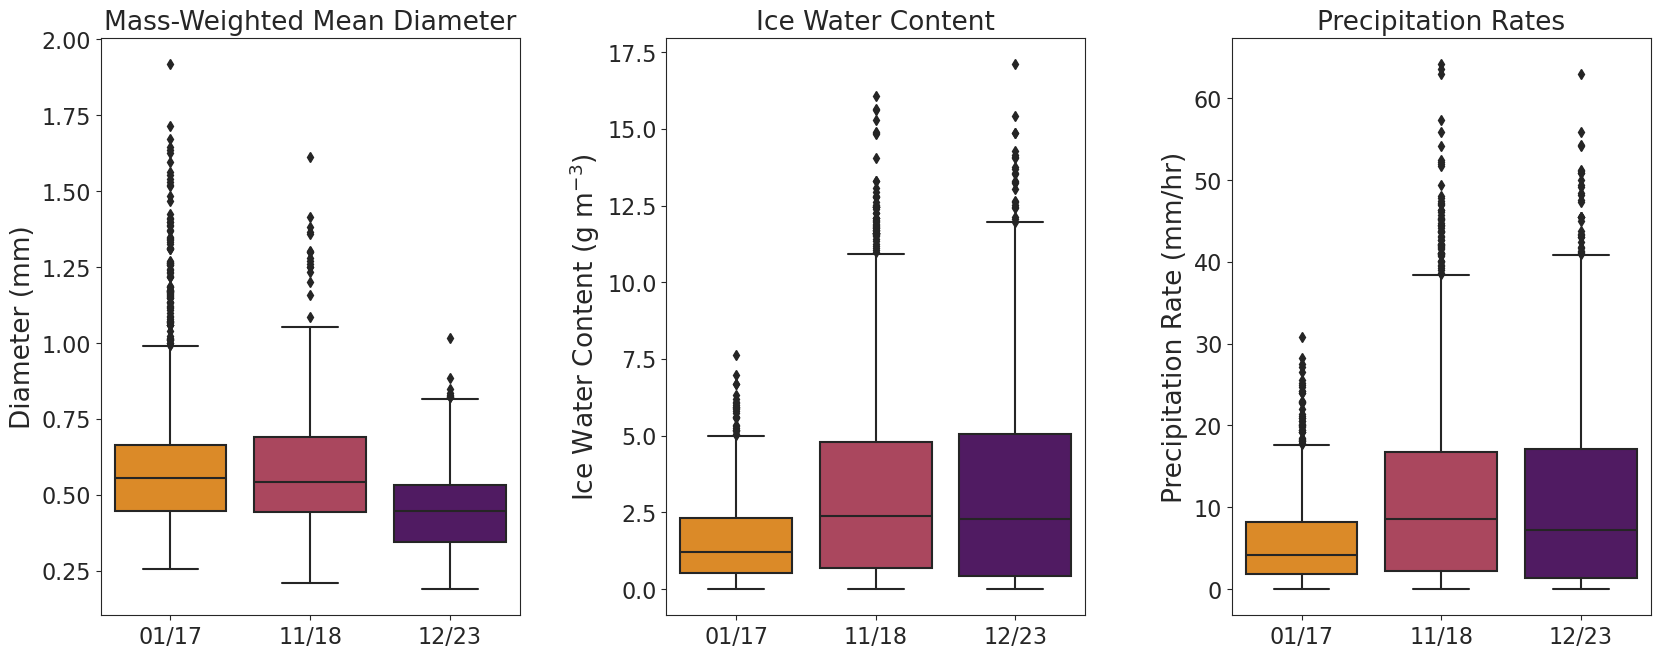

In [5]:
def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    return [float('nan') if x==0 else x for x in values]
all_dms[:,0] = zero_to_nan(all_dms[:,0])
all_IWC[:,0] = zero_to_nan(all_IWC[:,0])
all_IWC[:,1] = zero_to_nan(all_IWC[:,1])
all_IWC[:,2] = zero_to_nan(all_IWC[:,2])
all_precip_rates[:,0] = zero_to_nan(all_precip_rates[:,0])
all_precip_rates[:,1] = zero_to_nan(all_precip_rates[:,1])
all_precip_rates[:,2] = zero_to_nan(all_precip_rates[:,2])
all_Vts[:,0] = zero_to_nan(all_Vts[:,0])
all_vvds[:,0] = zero_to_nan(all_vvds[:,0])
all_vvds[:,1] = zero_to_nan(all_vvds[:,1])
all_vvds[:,2] = zero_to_nan(all_vvds[:,2])

fig, axes = plt.subplots(1, 3, figsize=(20, 7.5))
plt.subplots_adjust(wspace=0.35)
calibri_font_path = '/data/keeling/a/mp46/Research/Data_Processing_Scripts/BUF_Scripts/calibri.ttf'

sns.boxplot(ax=axes[0], data=all_dms, palette = 'inferno_r')
axes[0].set_title('Mass-Weighted Mean Diameter',fontname=calibri_font_path, fontsize = 19)
#axes[0].set_ylim(0, 0.2)
axes[0].set_ylabel('Diameter (mm)', fontname=calibri_font_path, fontsize = 19)
#axes[0].set_xlabel('Case')
axes[0].set_xticklabels(['01/17','11/18','12/23'],fontname=calibri_font_path)
axes[0].tick_params(axis='both', labelsize=16)

# Charmander
sns.boxplot(ax=axes[1], data=all_IWC, palette = 'inferno_r')
axes[1].set_title('Ice Water Content', fontname=calibri_font_path, fontsize = 19)
axes[1].set_ylabel('Ice Water Content (g m$^{-3}$)',fontname=calibri_font_path, fontsize = 19)
axes[1].set_xticklabels(['01/17','11/18','12/23'],fontname=calibri_font_path)
axes[1].tick_params(axis='both', labelsize=16)

# Squirtle
sns.boxplot(ax=axes[2], data=all_precip_rates, palette = 'inferno_r')
axes[2].set_title('Precipitation Rates', fontname=calibri_font_path, fontsize = 19)
axes[2].set_ylabel('Precipitation Rate (mm/hr)',fontname=calibri_font_path, fontsize = 19)
axes[2].set_xticklabels(['01/17','11/18','12/23'],fontname=calibri_font_path)
axes[2].tick_params(axis='both', labelsize=16)


#sns.boxplot(ax=axes[3], data=all_vvds, palette = 'inferno_r')
#axes[3].set_title('Reflecitivty-Weighted Mean Velocities',fontname=calibri_font_path)
#axes[3].set_ylabel('Velocity (m/s)',fontname=calibri_font_path)
#axes[3].set_xticklabels(['20220117','20221118','20221223'],fontname=calibri_font_path)

savedimage = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/Box_Plot_BUF.png'
plt.savefig(savedimage,dpi=150)

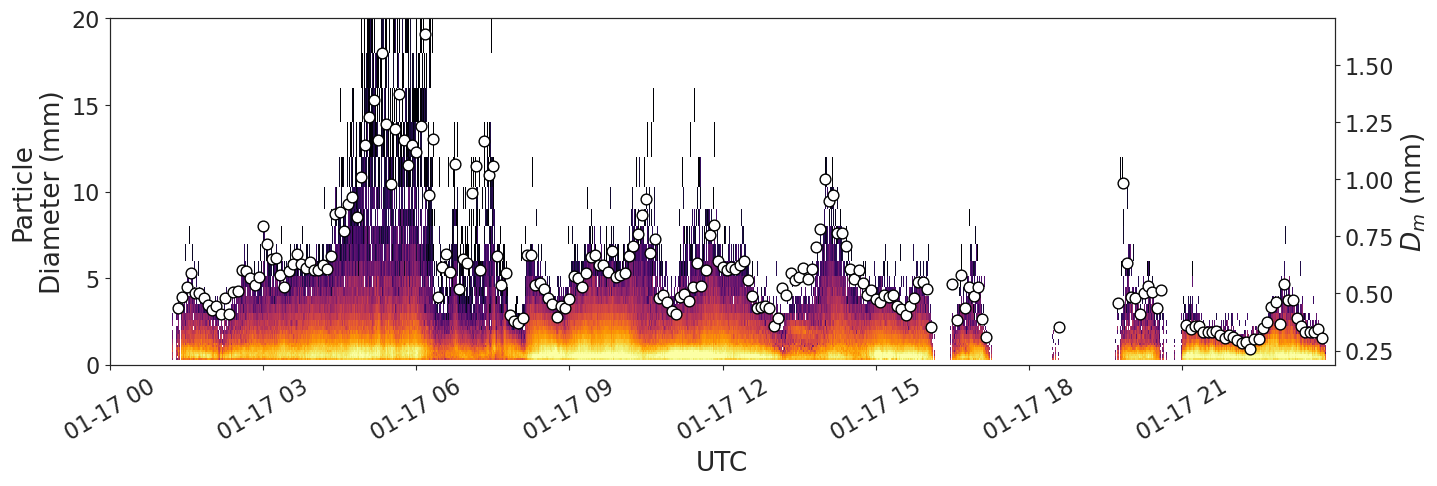

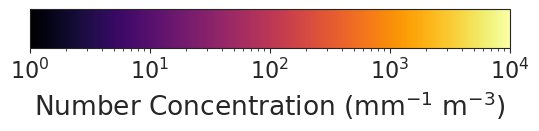

In [6]:

fig = plt.figure(figsize=(15.81,4.5))

#YlOrBr = cm.get_cmap('Blues', 256)
#newcmp = ListedColormap(BuPu(np.linspace(0.25, 0.75, 224)))

cb=plt.pcolormesh(pd.to_datetime(timestamps20220117),drop_diameter,psd20220117.T, norm=LogNorm(vmin=1e-0, vmax=10000),cmap = 'inferno')
#fig.colorbar(cb, ax=ax[0], label = 'Number Concentration\n(mm$^{-1}$ m$^{-3}$)', extend = 'min',)
plt.ylabel('Particle\nDiameter (mm)',fontsize = 19)
plt.ylim([0, 20])
#x = ['01-17 00', '01-17 03', '01-17 06', '01-17 09', '01-17 12', '01-17 15', '01-17 18', '01-17 21']
plt.xticks(rotation=30)
plt.xlabel('UTC',fontsize = 19)
plt.tick_params(axis='both', labelsize=16)
#plt.title('Precipitation Rates', fontname=calibri_font_path, fontsize = 19)

ax2 = plt.twinx()
ax2.scatter(pd.to_datetime(timestamps20220117[::5]), dm20220117[::5], color='#FFFFFF', edgecolors= 'black', s=60, label = 'Dm')
ax2.set_ylabel('$D_m$ (mm)',fontsize = 19)
ax2.tick_params(axis='y',labelsize=16)
#ax2.set_ylim([0, 20])
#ax[0].set_xlim([xlimindexstart, xlimindexend+pd.Timedelta(minutes=1)])

import matplotlib.dates as mdates
xformatter = mdates.DateFormatter('%m-%d %H')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

#fig.suptitle('20220117 UIUC SCAMP - Lancaster, NY',fontsize=15);
savedimage = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/Event_PSD_BUF_20220117.png'
plt.savefig(savedimage,dpi=300, bbox_inches='tight')

# Create a separate horizontal colorbar
fig_colorbar = plt.figure(figsize=(6, 0.65))  # Adjust size as needed
colorbar_ax = fig_colorbar.add_axes([0.1, 0.2, 0.8, 0.6])  # Adjust position and size as needed
colorbar = plt.colorbar(cb,cax=colorbar_ax, orientation='horizontal')
colorbar.set_label('Number Concentration (mm$^{-1}$ m$^{-3}$)', fontsize = 19)
colorbar.ax.tick_params(labelsize = 16)
savedimage = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/PSD_ColourBar.png'
plt.savefig(savedimage,dpi=300, bbox_inches='tight')
#colorbar.set_ticklabels(['10$^{0}$','10$^{1}$','10$^{2}$','10$^{3}$','10$^{4}$'])

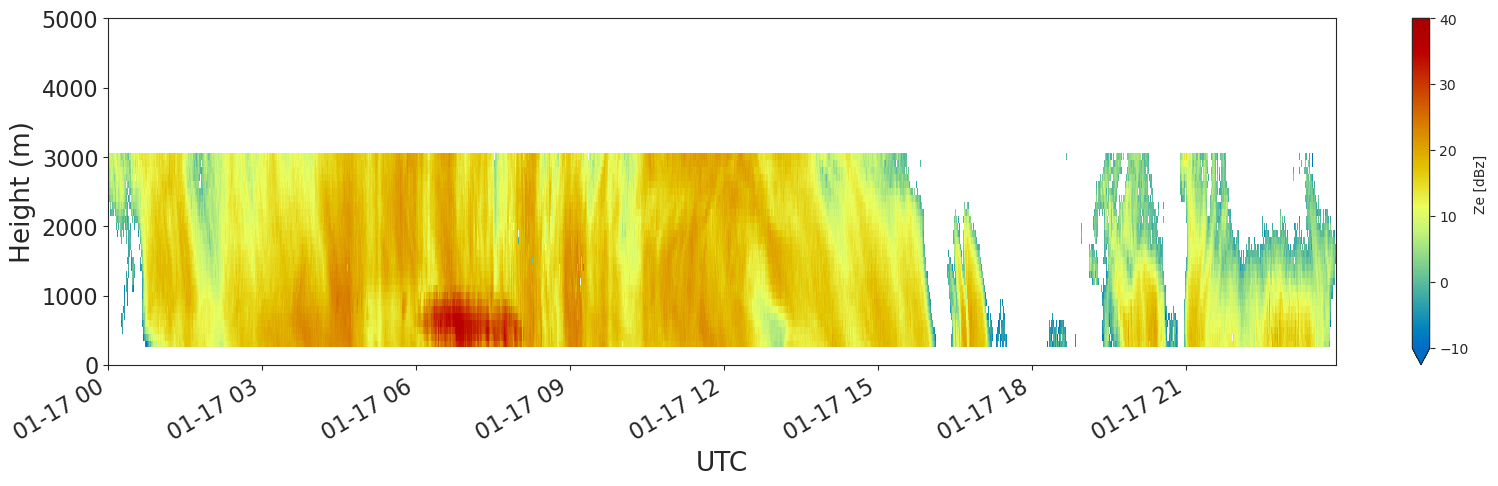

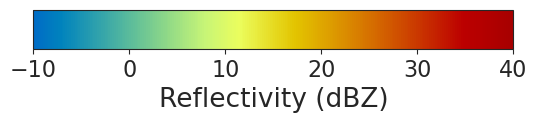

In [7]:
#fig = plt.figure(figsize=(15,5))
#ax=fig.subplots(nrows=2,ncols=1,sharex=True)
fig = plt.figure(figsize=(19.8,4.5))

mrr = mrr20220117['Ze'].T.plot(vmin=-10,vmax=40,cmap="pyart_HomeyerRainbow")
plt.ylim([0, 5000])
plt.ylabel('Height (m)',fontname=calibri_font_path, fontsize = 19)
plt.xlabel('UTC',fontname=calibri_font_path, fontsize = 19)
plt.tick_params(axis='both', labelsize=16)

import matplotlib.dates as mdates
xformatter = mdates.DateFormatter('%m-%d %H')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

#fig.suptitle('20220117 UIUC SCAMP - Lancaster, NY',fontsize=15);
savedimage = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/Event_MRR_BUF_20220117.png'
plt.savefig(savedimage,dpi=300, bbox_inches='tight')

# Create a separate horizontal colorbar
fig_colorbar = plt.figure(figsize=(6, 0.65))  # Adjust size as needed
colorbar_ax = fig_colorbar.add_axes([0.1, 0.2, 0.8, 0.6])  # Adjust position and size as needed
colorbar = plt.colorbar(mrr,cax=colorbar_ax, orientation='horizontal')
colorbar.set_label('Reflectivity (dBZ)', fontsize = 19)
colorbar.ax.tick_params(labelsize = 16)
savedimage = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/MRR_ColourBar.png'
plt.savefig(savedimage,dpi=300, bbox_inches='tight')

In [8]:
'''
#fig = plt.figure(figsize=(15,5))
#ax=fig.subplots(nrows=2,ncols=1,sharex=True)
fig = plt.figure(figsize=(25,2.5))
ax=fig.subplots(nrows=1,ncols=2,sharex=True)

#YlOrBr = cm.get_cmap('Blues', 256)
#newcmp = ListedColormap(BuPu(np.linspace(0.25, 0.75, 224)))

cb=ax[0].pcolormesh(pd.to_datetime(timestamps20221118),drop_diameter,psd20221118.T, norm=LogNorm(vmin=1e-0, vmax=10000),cmap = 'inferno')
fig.colorbar(cb, ax=ax[0], label = 'Number Concentration\n(mm$^{-1}$ m$^{-3}$)', extend = 'min')
ax[0].set_ylabel('Particle\nDiameter (mm)',fontname=calibri_font_path)
ax[0].set_ylim([0, 20])
x = ['12-23 00', '12-23 12', '12-24 00', '12-24 12', '12-25 00', '12-25 12']
ax[0].set_xticklabels(x, rotation=30,fontname=calibri_font_path)
ax[0].set_xlabel('UTC',fontname=calibri_font_path)
#ax[0].set_xlim([xlimindexstart, xlimindexend+pd.Timedelta(minutes=1)])

mrr_plot = full_mrr20221118['Ze'].T.plot(ax =ax[1], vmin=-10,vmax=40,cmap="pyart_HomeyerRainbow")
ax[1].set_ylim([0, 3000])
ax[1].set_ylabel('Height (m)',fontname=calibri_font_path)
ax[1].set_xlabel('UTC',fontname=calibri_font_path)

import matplotlib.dates as mdates
xformatter = mdates.DateFormatter('%m-%d %H')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

#fig.suptitle('20220117 UIUC SCAMP - Lancaster, NY',fontsize=15);
plt.tight_layout()
savedimage = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/Parsivel_MRR_Horiz_BUF_20221118.png'
plt.savefig(savedimage)
'''

'\n#fig = plt.figure(figsize=(15,5))\n#ax=fig.subplots(nrows=2,ncols=1,sharex=True)\nfig = plt.figure(figsize=(25,2.5))\nax=fig.subplots(nrows=1,ncols=2,sharex=True)\n\n#YlOrBr = cm.get_cmap(\'Blues\', 256)\n#newcmp = ListedColormap(BuPu(np.linspace(0.25, 0.75, 224)))\n\ncb=ax[0].pcolormesh(pd.to_datetime(timestamps20221118),drop_diameter,psd20221118.T, norm=LogNorm(vmin=1e-0, vmax=10000),cmap = \'inferno\')\nfig.colorbar(cb, ax=ax[0], label = \'Number Concentration\n(mm$^{-1}$ m$^{-3}$)\', extend = \'min\')\nax[0].set_ylabel(\'Particle\nDiameter (mm)\',fontname=calibri_font_path)\nax[0].set_ylim([0, 20])\nx = [\'12-23 00\', \'12-23 12\', \'12-24 00\', \'12-24 12\', \'12-25 00\', \'12-25 12\']\nax[0].set_xticklabels(x, rotation=30,fontname=calibri_font_path)\nax[0].set_xlabel(\'UTC\',fontname=calibri_font_path)\n#ax[0].set_xlim([xlimindexstart, xlimindexend+pd.Timedelta(minutes=1)])\n\nmrr_plot = full_mrr20221118[\'Ze\'].T.plot(ax =ax[1], vmin=-10,vmax=40,cmap="pyart_HomeyerRainbow")\n

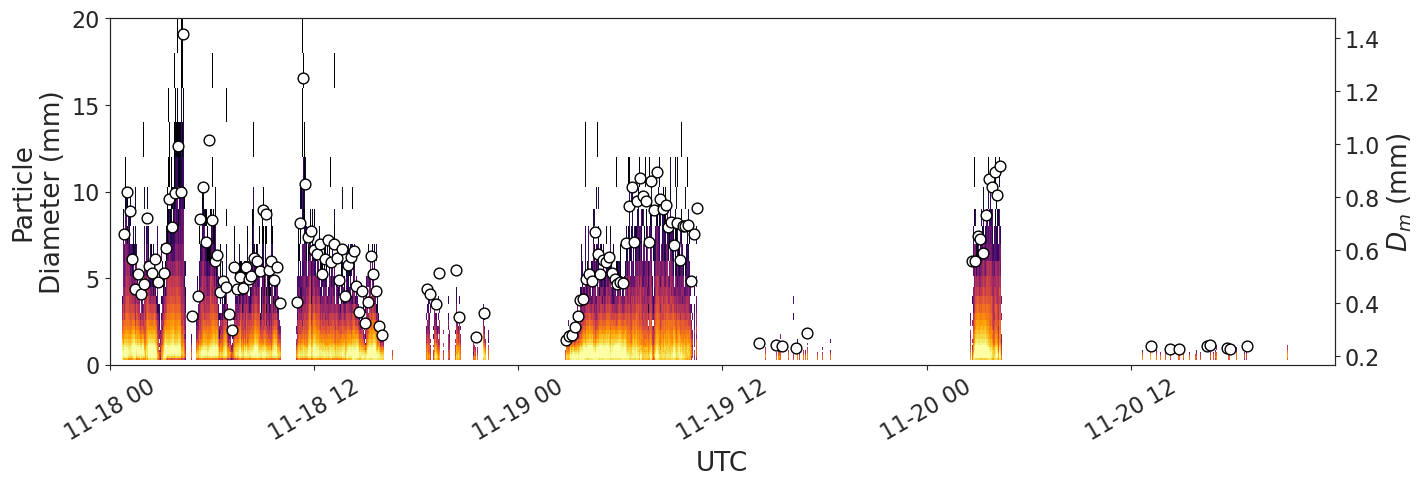

In [9]:
fig = plt.figure(figsize=(15.81,4.5))

cb=plt.pcolormesh(pd.to_datetime(timestamps20221118),drop_diameter,psd20221118.T, norm=LogNorm(vmin=1e-0, vmax=10000),cmap = 'inferno')
#fig.colorbar(cb, ax=ax[0], label = 'Number Concentration\n(mm$^{-1}$ m$^{-3}$)', extend = 'min',)
plt.ylabel('Particle\nDiameter (mm)',fontname=calibri_font_path, fontsize = 19)
plt.ylim([0, 20])
plt.xticks(rotation=30)
plt.xlabel('UTC',fontname=calibri_font_path, fontsize = 19)
plt.tick_params(axis='both', labelsize=16)
#plt.title('Precipitation Rates', fontname=calibri_font_path, fontsize = 19)

ax2 = plt.twinx()
ax2.scatter(pd.to_datetime(timestamps20221118[::10]), dm20221118[::10], color='#FFFFFF', edgecolors= 'black', s=60, label = 'Dm')
ax2.set_ylabel('$D_m$ (mm)',fontsize = 19)
ax2.tick_params(axis='y',labelsize=16)



import matplotlib.dates as mdates
xformatter = mdates.DateFormatter('%m-%d %H')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

#fig.suptitle('20220117 UIUC SCAMP - Lancaster, NY',fontsize=15);
savedimage = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/Event_PSD_BUF_20221118.png'
plt.savefig(savedimage,dpi=300, bbox_inches='tight')

In [10]:
fig = plt.figure(figsize=(19.8,4.5))

full_mrr20221118['Ze'].T.plot(vmin=-10,vmax=40,cmap="pyart_HomeyerRainbow")
plt.ylim([0, 3000])
plt.ylabel('Height (m)',fontname=calibri_font_path, fontsize = 19)
plt.xlabel('UTC',fontname=calibri_font_path, fontsize = 19)
plt.tick_params(axis='both', labelsize=16)

import matplotlib.dates as mdates
xformatter = mdates.DateFormatter('%m-%d %H')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

#fig.suptitle('20220117 UIUC SCAMP - Lancaster, NY',fontsize=15);
savedimage = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/Event_MRR_BUF_20221118.png'
plt.savefig(savedimage,dpi=300, bbox_inches='tight')

In [ ]:
'''
#fig = plt.figure(figsize=(15,7.5))
#ax=fig.subplots(nrows=2,ncols=1,sharex=False)
fig = plt.figure(figsize=(25,2.5))
ax=fig.subplots(nrows=1,ncols=2,sharex=True)

#YlOrBr = cm.get_cmap('Blues', 256)
#newcmp = ListedColormap(BuPu(np.linspace(0.25, 0.75, 224)))

cb=ax[0].pcolormesh(pd.to_datetime(timestamps20221223),drop_diameter,psd20221223.T, norm=LogNorm(vmin=1e-0, vmax=10000),cmap = 'inferno')
fig.colorbar(cb, ax=ax[0], label = 'Number Concentration\n(mm$^{-1}$ m$^{-3}$)', extend = 'min')
ax[0].set_ylabel('Particle\nDiameter (mm)',fontname=calibri_font_path)
ax[0].set_ylim([0, 20])
x = ['12-23 00', '12-23 12', '12-24 00', '12-24 12', '12-25 00', '12-25 12']
ax[0].set_xticklabels(x, rotation=30,fontname=calibri_font_path)
ax[0].set_xlabel('UTC',fontname=calibri_font_path)
#ax[0].set_xlim([xlimindexstart, xlimindexend+pd.Timedelta(minutes=1)])

full_mrr20221223['Ze'].T.plot(ax =ax[1], vmin=-10,vmax=40,cmap="pyart_HomeyerRainbow")
ax[1].set_ylim([0, 3000])
ax[1].set_ylabel('Height (m)',fontname=calibri_font_path)
ax[1].set_xlabel('UTC',fontname=calibri_font_path)

import matplotlib.dates as mdates
xformatter = mdates.DateFormatter('%m-%d %H')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

#fig.suptitle('20220117 UIUC SCAMP - Lancaster, NY',fontsize=15);
savedimage = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/Parsivel_MRR_Horiz_BUF_20221223.png'
plt.savefig(savedimage,dpi=200)
'''

'\n#fig = plt.figure(figsize=(15,7.5))\n#ax=fig.subplots(nrows=2,ncols=1,sharex=False)\nfig = plt.figure(figsize=(25,2.5))\nax=fig.subplots(nrows=1,ncols=2,sharex=True)\n\n#YlOrBr = cm.get_cmap(\'Blues\', 256)\n#newcmp = ListedColormap(BuPu(np.linspace(0.25, 0.75, 224)))\n\ncb=ax[0].pcolormesh(pd.to_datetime(timestamps20221223),drop_diameter,psd20221223.T, norm=LogNorm(vmin=1e-0, vmax=10000),cmap = \'inferno\')\nfig.colorbar(cb, ax=ax[0], label = \'Number Concentration\n(mm$^{-1}$ m$^{-3}$)\', extend = \'min\')\nax[0].set_ylabel(\'Particle\nDiameter (mm)\',fontname=calibri_font_path)\nax[0].set_ylim([0, 20])\nx = [\'12-23 00\', \'12-23 12\', \'12-24 00\', \'12-24 12\', \'12-25 00\', \'12-25 12\']\nax[0].set_xticklabels(x, rotation=30,fontname=calibri_font_path)\nax[0].set_xlabel(\'UTC\',fontname=calibri_font_path)\n#ax[0].set_xlim([xlimindexstart, xlimindexend+pd.Timedelta(minutes=1)])\n\nfull_mrr20221223[\'Ze\'].T.plot(ax =ax[1], vmin=-10,vmax=40,cmap="pyart_HomeyerRainbow")\nax[1].se

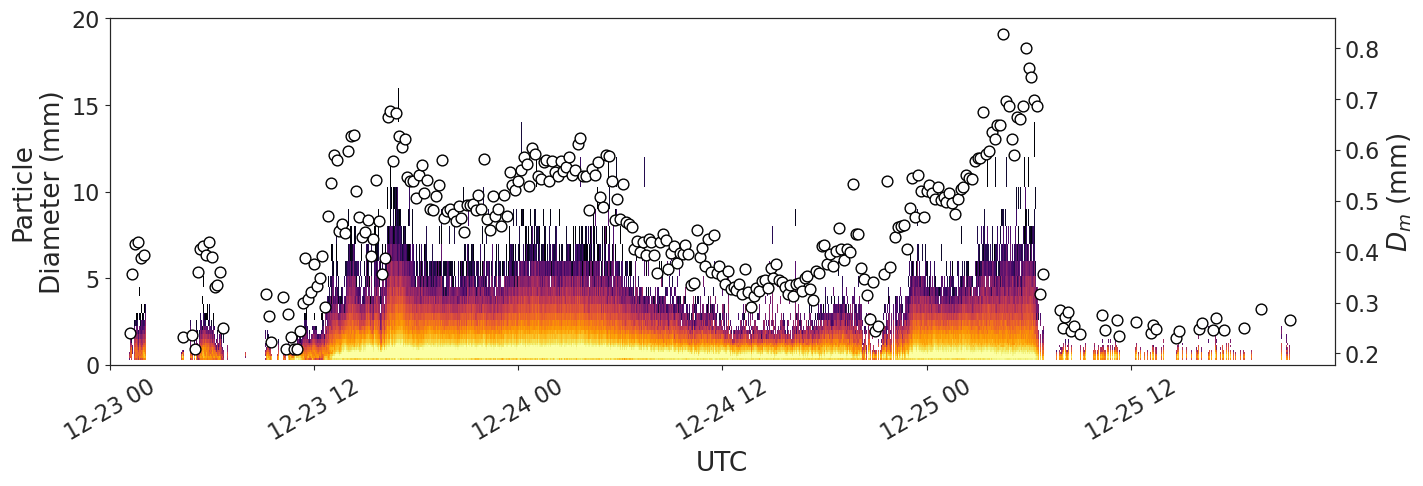

In [ ]:
fig = plt.figure(figsize=(15.81,4.5))

cb=plt.pcolormesh(pd.to_datetime(timestamps20221223),drop_diameter,psd20221223.T, norm=LogNorm(vmin=1e-0, vmax=10000),cmap = 'inferno')
#fig.colorbar(cb, ax=ax[0], label = 'Number Concentration\n(mm$^{-1}$ m$^{-3}$)', extend = 'min',)
plt.ylabel('Particle\nDiameter (mm)',fontname=calibri_font_path, fontsize = 19)
plt.ylim([0, 20])
plt.xticks(rotation=30)
plt.xlabel('UTC',fontname=calibri_font_path, fontsize = 19)
plt.tick_params(axis='both', labelsize=16)
#plt.title('Precipitation Rates', fontname=calibri_font_path, fontsize = 19)

ax2 = plt.twinx()
ax2.scatter(pd.to_datetime(timestamps20221223[::10]), dm20221223[::10], color='#FFFFFF', edgecolors= 'black', s=60, label = 'Dm')
ax2.set_ylabel('$D_m$ (mm)',fontsize = 19)
ax2.tick_params(axis='y',labelsize=16)
#ax2.set_ylim([0, 20])


import matplotlib.dates as mdates
xformatter = mdates.DateFormatter('%m-%d %H')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

#fig.suptitle('20220117 UIUC SCAMP - Lancaster, NY',fontsize=15);
savedimage = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/Event_PSD_BUF_20221223.png'
plt.savefig(savedimage,dpi=300, bbox_inches='tight')

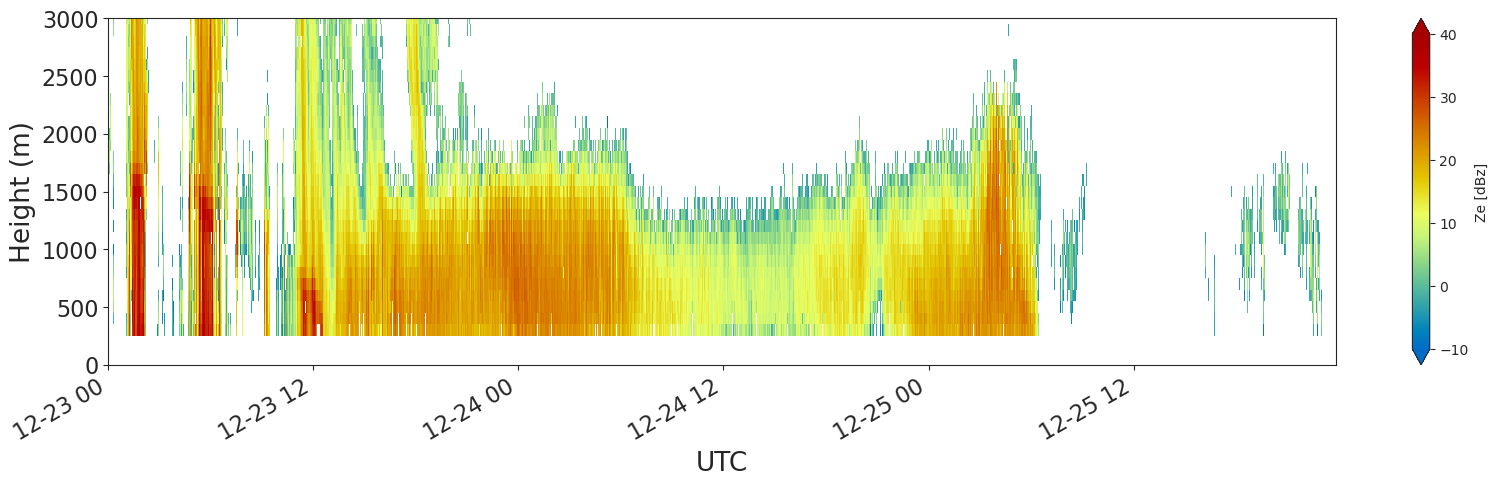

In [ ]:
fig = plt.figure(figsize=(19.8,4.5))

full_mrr20221223['Ze'].T.plot(vmin=-10,vmax=40,cmap="pyart_HomeyerRainbow")
plt.ylim([0, 3000])
plt.ylabel('Height (m)',fontname=calibri_font_path, fontsize = 19)
plt.xlabel('UTC',fontname=calibri_font_path, fontsize = 19)
plt.tick_params(axis='both', labelsize=16)

import matplotlib.dates as mdates
xformatter = mdates.DateFormatter('%m-%d %H')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

#fig.suptitle('20220117 UIUC SCAMP - Lancaster, NY',fontsize=15);
savedimage = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/Event_MRR_BUF_20221213.png'
plt.savefig(savedimage,dpi=300, bbox_inches='tight')

findfont: Font family ['/data/keeling/a/mp46/Research/Data_Processing_Scripts/BUF_Scripts/calibri.ttf'] not found. Falling back to DejaVu Sans.


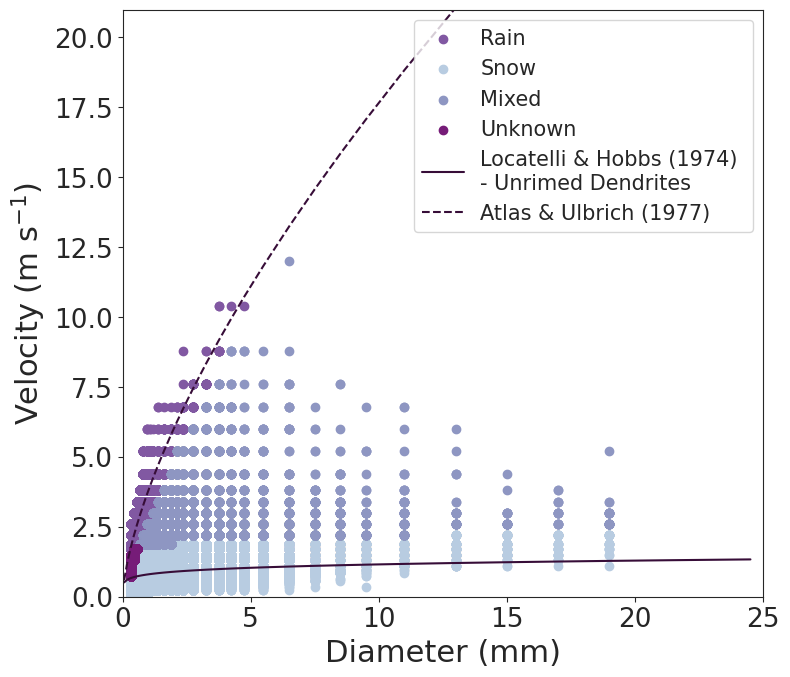

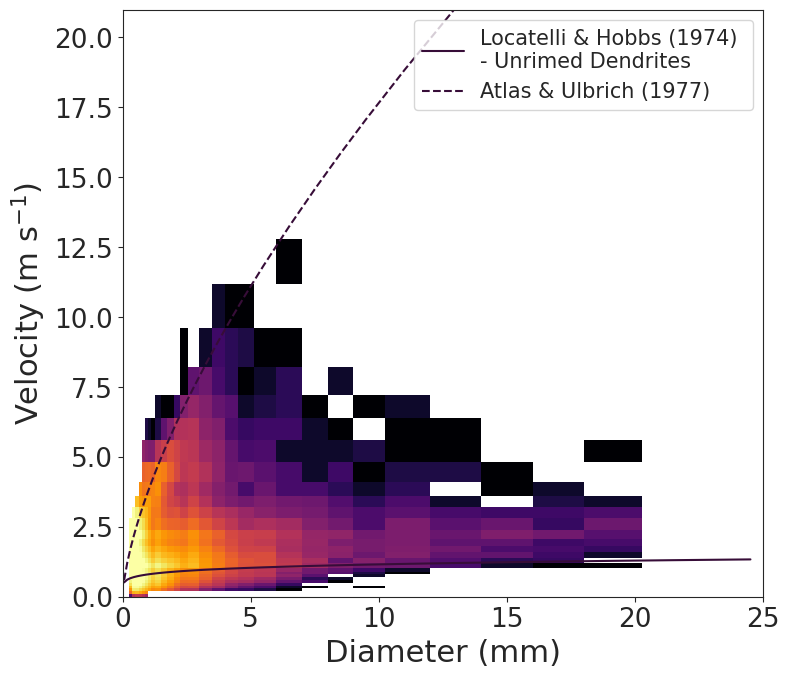

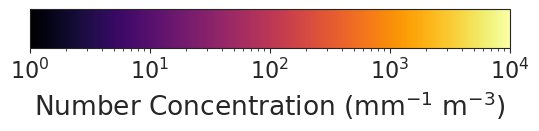

In [ ]:
fig = plt.figure(figsize=(8,6.875))

#ax=fig.subplots(nrows=1,ncols=1,sharex=True)

#if event_type == 'snow':
plt.scatter(rain_triple_time_dia_vel20220117[:,0],rain_triple_time_dia_vel20220117[:,1], label = 'Rain', color = '#8158a2')
plt.scatter(snow_triple_time_dia_vel20220117[:,0],snow_triple_time_dia_vel20220117[:,1], label = 'Snow', color = '#b8cce1')
plt.scatter(mixed_triple_time_dia_vel20220117[:,0],mixed_triple_time_dia_vel20220117[:,1], label = 'Mixed', color = '#8e96c2')
plt.scatter(unknown_triple_time_dia_vel20220117[:,0],unknown_triple_time_dia_vel20220117[:,1], label = 'Unknown', color = '#761c78')

#plt.plot(ds.diameter,(snow_pars[0])*np.power(ds.diameter/1000, snow_pars[1]), color = '#370D38', linestyle='solid', label = 'Snow Fitted Power Law')
#plt.plot(ds.diameter,(rain_pars[0])*np.power(ds.diameter/1000, rain_pars[1]), color='#370D38', linestyle='dashed', label = 'Rain Fitted Power Law')
plt.plot(ds.diameter,0.8*np.power(ds.diameter, 0.16), color = '#370D38', linestyle='solid', label = 'Locatelli & Hobbs (1974) \n- Unrimed Dendrites')
plt.plot(ds.diameter,17.67*np.power(ds.diameter/10, 0.67), color='#370D38', linestyle='dashed', label = 'Atlas & Ulbrich (1977)')
plt.legend(fontsize = 15, loc = 'upper right')
plt.xlabel('Diameter (mm)',fontname=calibri_font_path, fontsize = 22)
plt.ylabel('Velocity (m s$^{-1}$)',fontname=calibri_font_path, fontsize = 22)
plt.tick_params(axis='both', labelsize=19)

plt.ylim(0,21)
plt.xlim(0,25)

plt.tight_layout()
savedimage = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/Event_ScatterParsivel_Vt_vs_Diameter_BUF_20220117.png'
plt.savefig(savedimage,dpi=300, bbox_inches='tight')


fig = plt.figure(figsize=(8,6.875))

cb=plt.pcolormesh(ds.diameter,ds.velocity,summed_spectrum20220117, norm=LogNorm(vmin=1e-0, vmax=10000),cmap='inferno')
#vmin = 0, vmax=np.max(np.array(summed_spectrum)),cmap='inferno')
#cbaxes = inset_axes(fig, width="5%", height="10%", loc='upper right') 
#plt.colorbar(cb,cax=cbaxes,orientation='vertical') #label='# of Particles',

plt.plot(ds.diameter,0.8*np.power(ds.diameter, 0.16), color = '#370D38', linestyle='solid', label = 'Locatelli & Hobbs (1974) \n- Unrimed Dendrites')
plt.plot(ds.diameter,17.67*np.power(ds.diameter/10, 0.67), color='#370D38', linestyle='dashed', label = 'Atlas & Ulbrich (1977)')
plt.legend(fontsize = 15, loc = 'upper right')
plt.xlabel('Diameter (mm)', fontsize = 22)
plt.ylabel('Velocity (m s$^{-1}$)', fontsize = 22)
plt.tick_params(axis='both', labelsize=19)

plt.ylim(0,21)
plt.xlim(0,25)

plt.tight_layout()
savedimage = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/Event_DensityPlotParsivel_Vt_vs_Diameter_BUF_20220117.png'
plt.savefig(savedimage,dpi=300, bbox_inches='tight')

# Create a separate horizontal colorbar
fig_colorbar = plt.figure(figsize=(6, 0.65))  # Adjust size as needed
colorbar_ax = fig_colorbar.add_axes([0.1, 0.2, 0.8, 0.6])  # Adjust position and size as needed
colorbar = plt.colorbar(cb,cax=colorbar_ax, orientation='horizontal')
colorbar.set_label('Number Concentration (mm$^{-1}$ m$^{-3}$)', fontsize = 19)
colorbar.ax.tick_params(labelsize = 16)

savedimage = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/DensityPlot_ColourBar.png'
plt.savefig(savedimage,dpi=300, bbox_inches='tight')

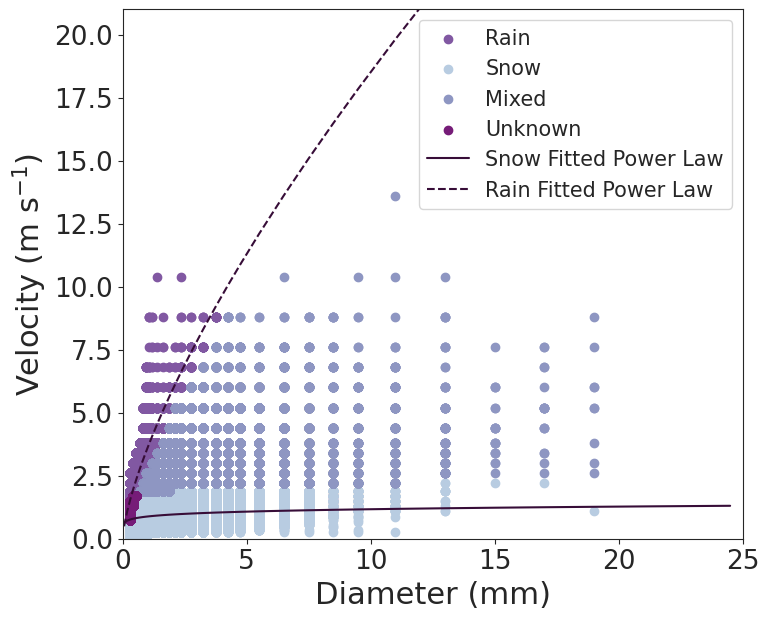

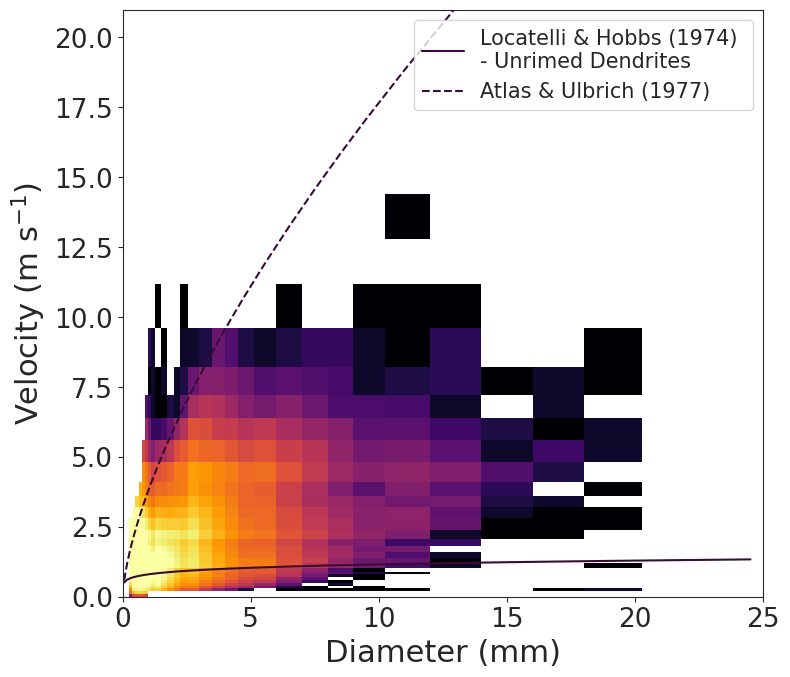

In [ ]:
fig = plt.figure(figsize=(8,6.875))

#ax=fig.subplots(nrows=1,ncols=1,sharex=True)

#if event_type == 'snow':
plt.scatter(rain_triple_time_dia_vel20221118[:,0],rain_triple_time_dia_vel20221118[:,1], label = 'Rain', color = '#8158a2')#,alpha=0.1)
plt.scatter(snow_triple_time_dia_vel20221118[:,0],snow_triple_time_dia_vel20221118[:,1], label = 'Snow', color = '#b8cce1')#,alpha=0.1)
plt.scatter(mixed_triple_time_dia_vel20221118[:,0],mixed_triple_time_dia_vel20221118[:,1], label = 'Mixed', color = '#8e96c2')#,alpha=0.1)
plt.scatter(unknown_triple_time_dia_vel20221118[:,0],unknown_triple_time_dia_vel20221118[:,1], label = 'Unknown', color = '#761c78')#,alpha=0.1)

plt.plot(ds.diameter,(snow_pars[0])*np.power(ds.diameter/1000, snow_pars[1]), color = '#370D38', linestyle='solid', label = 'Snow Fitted Power Law')
plt.plot(ds.diameter,(rain_pars[0])*np.power(ds.diameter/1000, rain_pars[1]), color='#370D38', linestyle='dashed', label = 'Rain Fitted Power Law')
#plt.plot(ds.diameter,0.8*np.power(ds.diameter, 0.16), color='#2F353D', label = 'Locatelli & Hobbs (1974) \n- Unrimed Dendrites')
plt.legend(fontsize = 15, loc = 'upper right')
plt.xlabel('Diameter (mm)',fontname=calibri_font_path, fontsize = 22)
plt.ylabel('Velocity (m s$^{-1}$)',fontname=calibri_font_path, fontsize = 22)
plt.tick_params(axis='both', labelsize=19)

plt.ylim(0,21)
plt.xlim(0,25)

savedimage = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/Event_ScatterParsivel_Vt_vs_Diameter_BUF_20221118.png'
plt.savefig(savedimage,dpi=150)


fig = plt.figure(figsize=(8,6.875))

cb=plt.pcolormesh(ds.diameter,ds.velocity,summed_spectrum20221118, norm=LogNorm(vmin=1e-0, vmax=10000),cmap='inferno')
#vmin = 0, vmax=np.max(np.array(summed_spectrum)),cmap='inferno')
#cbaxes = inset_axes(ax[0], width="5%", height="10%", loc='upper right') 
#plt.colorbar(cb,cax=cbaxes,orientation='vertical') #label='# of Particles',

plt.plot(ds.diameter,0.8*np.power(ds.diameter, 0.16), color = '#370D38', linestyle='solid', label = 'Locatelli & Hobbs (1974) \n- Unrimed Dendrites')
plt.plot(ds.diameter,17.67*np.power(ds.diameter/10, 0.67), color='#370D38', linestyle='dashed', label = 'Atlas & Ulbrich (1977)')
plt.legend(fontsize = 15, loc = 'upper right')
plt.xlabel('Diameter (mm)', fontsize = 22)
plt.ylabel('Velocity (m s$^{-1}$)', fontsize = 22)
plt.tick_params(axis='both', labelsize=19)

plt.ylim(0,21)
plt.xlim(0,25)

plt.tight_layout()
savedimage = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/Event_DensityPlotParsivel_Vt_vs_Diameter_BUF_20221118.png'
plt.savefig(savedimage,dpi=300, bbox_inches='tight')

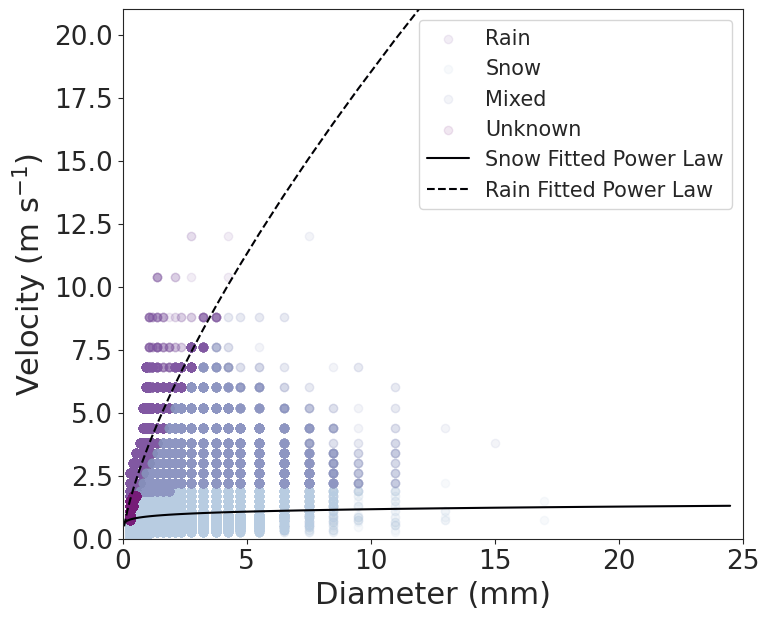

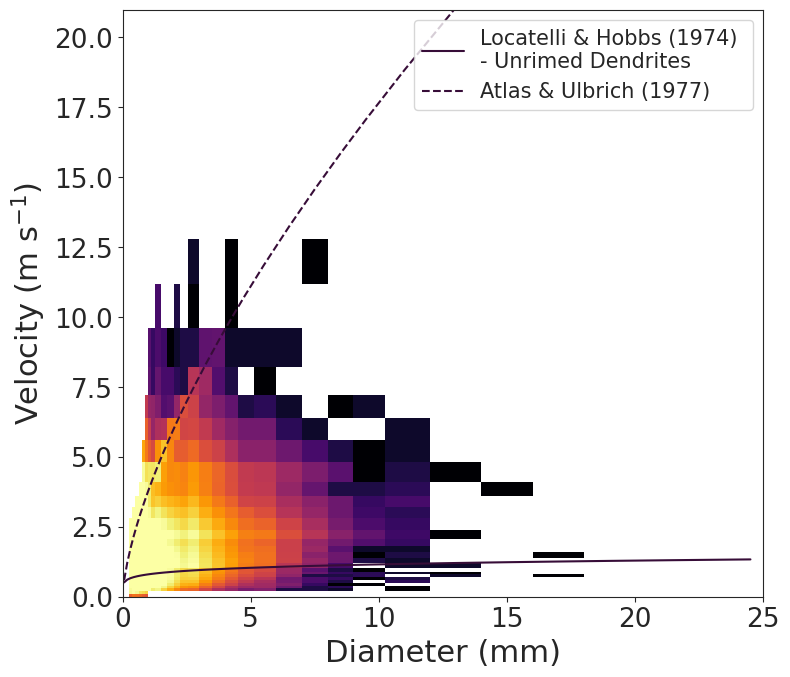

In [ ]:
fig = plt.figure(figsize=(8,6.875))

#ax=fig.subplots(nrows=1,ncols=1,sharex=True)

plt.scatter(rain_triple_time_dia_vel20221223[:,0],rain_triple_time_dia_vel20221223[:,1], label = 'Rain', color = '#8158a2',alpha=0.1)
plt.scatter(snow_triple_time_dia_vel20221223[:,0],snow_triple_time_dia_vel20221223[:,1], label = 'Snow', color = '#b8cce1',alpha=0.1)
plt.scatter(mixed_triple_time_dia_vel20221223[:,0],mixed_triple_time_dia_vel20221223[:,1], label = 'Mixed', color = '#8e96c2',alpha=0.1)
plt.scatter(unknown_triple_time_dia_vel20221223[:,0],unknown_triple_time_dia_vel20221223[:,1], label = 'Unknown', color = '#761c78',alpha=0.1)

plt.plot(ds.diameter,(snow_pars[0])*np.power(ds.diameter/1000, snow_pars[1]), color = '#010105', linestyle='solid', label = 'Snow Fitted Power Law')
plt.plot(ds.diameter,(rain_pars[0])*np.power(ds.diameter/1000, rain_pars[1]), color='#010105', linestyle='dashed', label = 'Rain Fitted Power Law')
#plt.plot(ds.diameter,0.8*np.power(ds.diameter, 0.16), color='#2F353D', label = 'Locatelli & Hobbs (1974) \n- Unrimed Dendrites')
plt.legend(fontsize = 15, loc = 'upper right')
plt.xlabel('Diameter (mm)',fontname=calibri_font_path, fontsize = 22)
plt.ylabel('Velocity (m s$^{-1}$)',fontname=calibri_font_path, fontsize = 22)
plt.tick_params(axis='both', labelsize=19)

plt.ylim(0,21)
plt.xlim(0,25)

savedimage = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/Event_ScatterParsivel_Vt_vs_Diameter_BUF_20221223.png'
plt.savefig(savedimage,dpi=150)

fig = plt.figure(figsize=(8,6.875))

cb=plt.pcolormesh(ds.diameter,ds.velocity,summed_spectrum20221223, norm=LogNorm(vmin=1e-0, vmax=10000),cmap='inferno')
#vmin = 0, vmax=np.max(np.array(summed_spectrum)),cmap='inferno')
#cbaxes = inset_axes(ax[0], width="5%", height="10%", loc='upper right') 
#plt.colorbar(cb,cax=cbaxes,orientation='vertical') #label='# of Particles',

plt.plot(ds.diameter,0.8*np.power(ds.diameter, 0.16), color = '#370D38', linestyle='solid', label = 'Locatelli & Hobbs (1974) \n- Unrimed Dendrites')
plt.plot(ds.diameter,17.67*np.power(ds.diameter/10, 0.67), color='#370D38', linestyle='dashed', label = 'Atlas & Ulbrich (1977)')
plt.legend(fontsize = 15, loc = 'upper right')
plt.xlabel('Diameter (mm)', fontsize = 22)
plt.ylabel('Velocity (m s$^{-1}$)', fontsize = 22)
plt.tick_params(axis='both', labelsize=19)

plt.ylim(0,21)
plt.xlim(0,25)


plt.tight_layout()
savedimage = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/Event_DensityPlotParsivel_Vt_vs_Diameter_BUF_20221223.png'
plt.savefig(savedimage,dpi=300, bbox_inches='tight')